# MU4MEN01 - Introduction à l'optimisation

## Projet : Dimensionnement de stockage embarqué dans un tramway

### Objectifs du projet :

Lors de ce projet d'optimisation, nous essaierons de :
- Mettre en œuvre une démarche d’optimisation pour la conception d’un système,
- Comprendre le principe de l’alimentation électrique des tramways,
- Découvrir l’optimisation multi-critères et le concept d’optimalité au  sens de Pareto,
- Et mettre en œuvre l’algorithme génétique `NSGA-2`. 
___

### Étudiants : Jacques GUÉRIN (21112101) - William WU (21107936)
- mail 1 : jacques.guerin@etu.sorbonne-universite.fr
- mail 2 : William.Wu@etu.sorbonne-universite.fr
___

# Bibliothèques

In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt

# 2.1 Mise en place du modèle du système

Longueur de la ligne : 1246.44348144531 m
Simulation avec une capacité de batterie de 5.0 MJ
Simulation sans batterie...
Affichage des résultats...


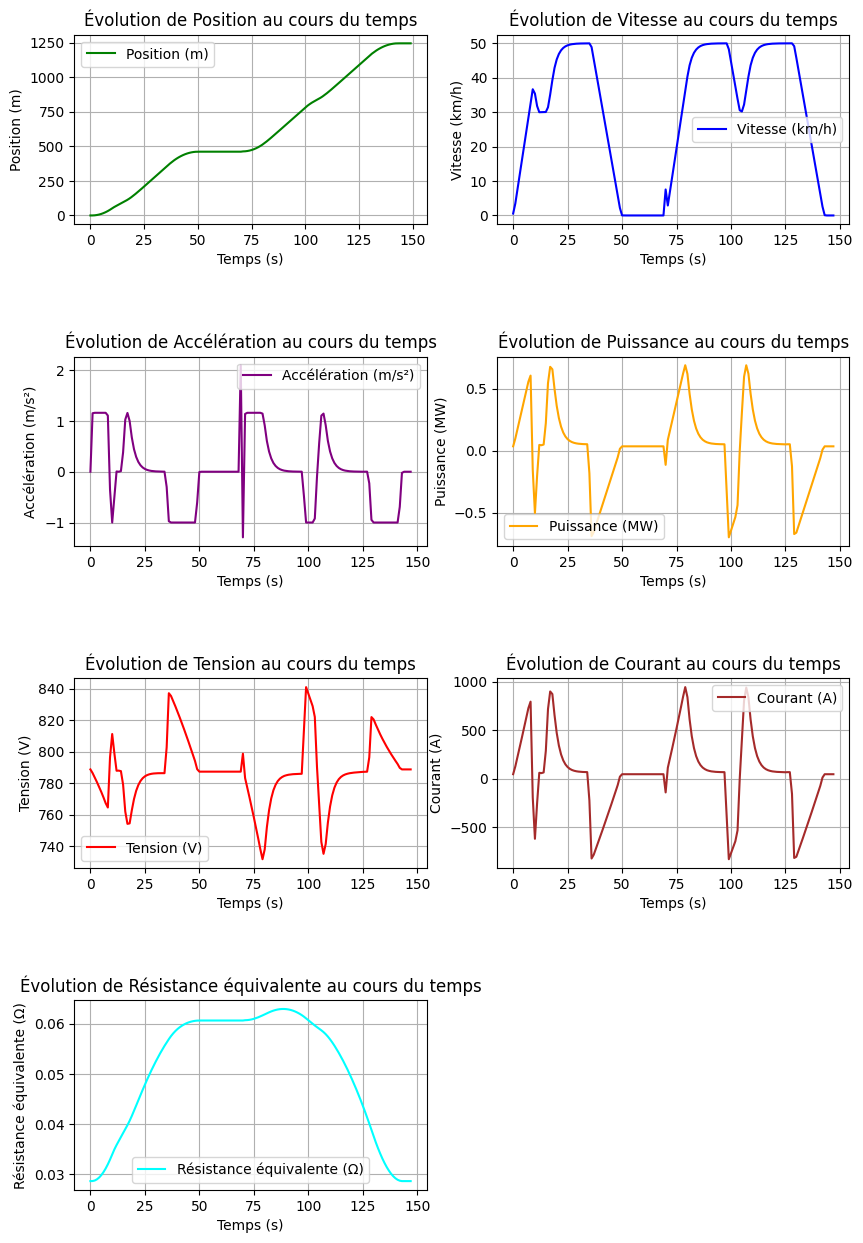

Simulation avec batterie...
Affichage des résultats...


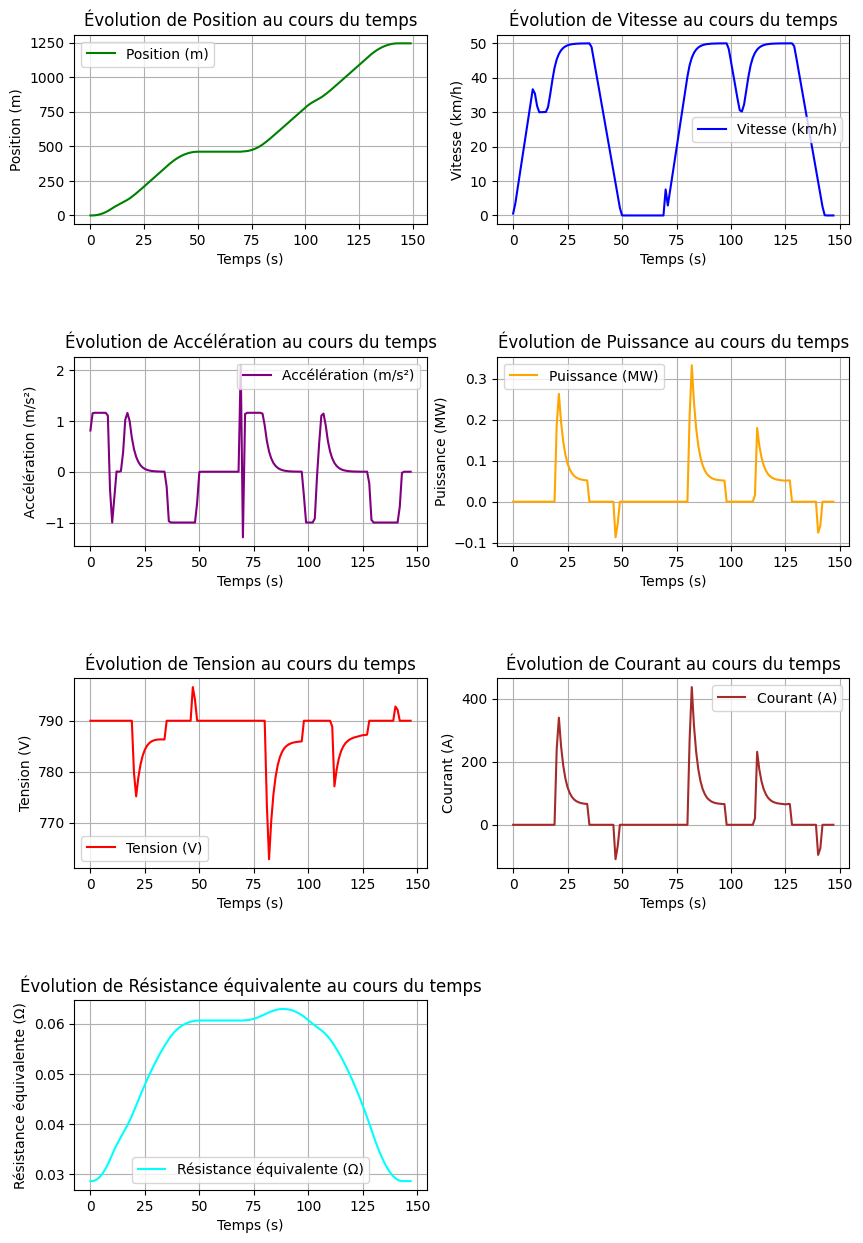

In [3]:
### Données initiales

V_s = 790           # Tension nominale (V)
R_s = 33e-3         # Résistance interne (ohms)
rho_lac = 131e-6    # Résistance linéique LAC (ohms/m)
rho_rail = 18e-6    # Résistance linéique rail (ohms/m)
M = 70_000          # Masse du train (kg)
P_bord = 35_000     # Consommation électrique à bord (W)
rendement = 0.8     # Rendement global

### Création d'une classe pour optimiser les tracés:

class Data:
    def __init__(self, temps, valeurs, nom, unite, couleur="blue"):
        """
        Initialisation de l'objet Data.

        Arguments :
        - temps (array) : Les valeurs de temps associées.
        - valeurs (array) : Les valeurs à tracer.
        - nom (str) : Le nom des données (ex. 'Vitesse', 'Position').
        - unite (str) : L'unité des données (ex. 'm/s', 'V').
        - couleur (str) : Couleur de la courbe (par défaut : "blue").
        """
        self.temps = temps
        self.valeurs = valeurs
        self.nom = nom
        self.unite = unite
        self.couleur = couleur

    def tracer(self):
        """
        Trace les données avec un titre et des étiquettes adaptés.
        """
        plt.plot(self.temps, self.valeurs, label=f"{self.nom} ({self.unite})", color=self.couleur)
        plt.xlabel("Temps (s)")
        plt.ylabel(f"{self.nom} ({self.unite})")
        plt.title(f"Évolution de {self.nom} au cours du temps")
        plt.legend()
        plt.grid()

    def afficher(self):
        """
        Affiche directement le tracé des données.
        """
        self.tracer()
        plt.show()

### Les fonctions de calcul

def calcul_resistance(distance, rho):
    '''Calcul de la résistance entre sous-station et train.'''
    return rho * distance

def puissance_mecanique(vitesse, acceleration, alpha):
    '''Calcule de la puissance mécanique nécessaire.'''
    # Coefficients de résistance
    A = 780
    A_t = 6.4
    B = 0
    B_t = 0.14
    C = 0.3634
    C_t = 0

    F_resistance = (A + A_t * M / 1_000) + (B + B_t * M / 1_000) * vitesse + (C + C_t * M / 1_000) * vitesse**2
    F_gravite = M * 9.81 * np.sin(np.radians(alpha))
    F_motrice = F_resistance + F_gravite + (M * acceleration)
    return F_motrice * vitesse

def puissance_electrique(p_mec):
    '''Calcul de la puissance électrique à partir de la mécanique.'''
    return p_mec * rendement

def tension_train(P_train, R_eq):
    '''Calcul de Tension aux bornes du train.
    Résolution de l'équation : V^2 - V*V_s + R_eq*P_train = 0.'''
    delta = V_s**2 - 4 * R_eq * P_train
    # Pour un delta négatif pas de solution
    if delta < 0:
        return None
    vitesse_1 = (V_s + np.sqrt(delta)) / 2
    vitesse_2 = (V_s - np.sqrt(delta)) / 2
    return max(vitesse_1, vitesse_2)

### Train en déplacement

def charger_donnees_train(fichier):
    """Charge les données de déplacement du train à partir d'un fichier texte.
    Arguments: 
        fichier (str): Chemin vers le fichier `marche.txt`.
    Renvoie:
        tuple (2 tableaux numpy): les temps et les positions."""
    try:
        data = np.loadtxt(fichier, delimiter='\t', dtype=float)
        temps = data[:, 0]  # Première colonne : temps
        positions = data[:, 1]  # Deuxième colonne : positions
        return temps, positions
    except Exception as e:
        print(f"Erreur lors du chargement des données : {e}")
        return None, None

def calcul_resistances(position, longueur_ligne):
    '''Calcul des résistances lorsque le train est en déplacement.'''
    distance_1 = position
    distance_2 = longueur_ligne - position
    R1 = calcul_resistance(distance_1, rho_lac + rho_rail) + R_s
    R2 = calcul_resistance(distance_2, rho_lac + rho_rail) + R_s
    return R1, R2

### Simulation sans batterie

def simulation_sans_batterie(temps, positions, longueur_ligne):
    """
    Fait la simulation du système sans batterie.
    
    Arguments :
        temps (array): Tableau des temps.
        positions (array): Tableau des positions.
        longueur_ligne (float): Longueur totale de la ligne.
    
    Retourne :
        tuple: Listes des tensions et des courants.
    """
    tensions = []
    courants = []
    puissances = []
    vitesses = []
    accelerations = []
    resistances_eq = []

    for i in range(len(temps) - 2):  # On boucle sur les indices des pas de temps
        # Résistances
        R1, R2 = calcul_resistances(positions[i], longueur_ligne)
        R_eq = (R1*R2) / (R1+R2)
        resistances_eq.append(R_eq)

        # Calcul de la vitesse (différence entre deux positions successives)
        dt1 = temps[i + 1] - temps[i]
        dt2 = temps[i + 2] - temps[i + 1]
        
        vitesse_1 = (positions[i+1] - positions[i]) / dt1 if dt1 != 0 else 0
        vitesse_2 = (positions[i+2] - positions[i+1]) / dt2 if dt2 != 0 else 0

        acceleration = (vitesse_2-vitesse_1) / (temps[i + 2] - temps[i + 1]) if i > 0 else 0

        # Puissance mécanique et électrique
        P_mec = puissance_mecanique(vitesse_1, acceleration, alpha = 0)
        P_train = puissance_electrique(P_mec) + P_bord

        # Tension aux bornes du train
        V_train = tension_train(P_train, R_eq)
        if V_train is None:
            raise ValueError(f"Pas de solution pour la tension au temps {temps[i]}")

        # Stocker les résultats
        vitesses.append(vitesse_1*3.6)          # Conversion en km/h
        accelerations.append(acceleration)
        tensions.append(V_train)
        puissances.append(P_train/(10**6))      # Conversion en MW
        courants.append(P_train / V_train)

    return resistances_eq, vitesses, accelerations, tensions, puissances, courants

### Simulation avec batterie

def simulation_avec_batterie(temps, positions, longueur_ligne, capacite_batterie):
    """
    Simule le système avec batterie.

    Arguments :
        temps (array): Tableau des temps.
        positions (array): Tableau des positions.
        longueur_ligne (float): Longueur totale de la ligne.
        capacite_batterie (float): Capacité maximale de la batterie (en joules).

    Retourne :
        tuple: Listes des tensions, courants, vitesses, accélérations, puissances et résistances.
    """
    tensions = []
    courants = []
    puissances = []
    vitesses = []
    accelerations = []
    resistances_eq = []

    energie_batterie = capacite_batterie  # État initial de la batterie (plein)
    
    for i in range(len(temps) - 2):  # On boucle sur les indices des pas de temps
        # Résistances
        R1, R2 = calcul_resistances(positions[i], longueur_ligne)
        R_eq = (R1 * R2) / (R1 + R2)
        resistances_eq.append(R_eq)

        # Calcul de la vitesse (différence entre deux positions successives)
        dt1 = temps[i + 1] - temps[i]
        dt2 = temps[i + 2] - temps[i + 1]
        
        vitesse_1 = (positions[i+1] - positions[i]) / dt1 if dt1 != 0 else 0
        vitesse_2 = (positions[i+2] - positions[i+1]) / dt2 if dt2 != 0 else 0

        # Calcul de l'accélération
        acceleration = (vitesse_2 - vitesse_1) / (temps[i + 2] - temps[i + 1]) if dt2 != 0 else 0

        # Puissance mécanique et électrique
        P_mec = puissance_mecanique(vitesse_1, acceleration, alpha=0)
        P_train = puissance_electrique(P_mec) + P_bord

        # Gestion de la batterie
        if P_train > 0:  # Le train consomme de la puissance
            if energie_batterie > 0:  # Si la batterie n'est pas vide
                # Fournir de l'énergie par la batterie
                P_batt = min(energie_batterie / dt1, P_train)  # Puissance max que la batterie peut fournir
                P_train -= P_batt  # Réduction de la puissance demandée à la LAC
                energie_batterie -= P_batt * dt1  # Mise à jour de l'énergie de la batterie
        elif P_train < 0:  # Le train freine (P_train négative)
            if energie_batterie < capacite_batterie:  # Si la batterie n'est pas pleine
                # Stocker l'énergie de freinage
                P_batt = min(-P_train, (capacite_batterie - energie_batterie) / dt1)
                energie_batterie += P_batt * dt1  # Mise à jour de l'énergie stockée
                P_train += P_batt  # Réduction de l'énergie dissipée dans le rhéostat

        # Tension aux bornes du train
        V_train = tension_train(P_train, R_eq)
        if V_train is None:
            raise ValueError(f"Pas de solution pour la tension au temps {temps[i]}")

        # Stocker les résultats
        vitesses.append(vitesse_1 * 3.6)  # Conversion en km/h
        accelerations.append(acceleration)
        tensions.append(V_train)
        puissances.append(P_train / (10**6))  # Conversion en MW
        courants.append(P_train / V_train)

    return resistances_eq, vitesses, accelerations, tensions, puissances, courants

### Affichage des résultats

def plot_all(temps, positions, vitesses, accelerations, puissances, tensions, courants, resistances_eq):
    """
    Trace tous les graphiques pour les données fournies.
    """
    plt.figure(figsize=(10, 15))
    plt.subplots_adjust(hspace=0.7)

    # Création des objets Data pour chaque série de données
    donnees = [
        Data(temps[:len(positions)], positions, "Position", "m", couleur="green"),
        Data(temps[:len(vitesses)], vitesses, "Vitesse", "km/h", couleur="blue"),
        Data(temps[:len(accelerations)], accelerations, "Accélération", "m/s²", couleur="purple"),
        Data(temps[:len(puissances)], puissances, "Puissance", "MW", couleur="orange"),
        Data(temps[:len(tensions)], tensions, "Tension", "V", couleur="red"),
        Data(temps[:len(courants)], courants, "Courant", "A", couleur="brown"),
        Data(temps[:len(resistances_eq)], resistances_eq, "Résistance équivalente", "Ω", couleur="cyan")
    ]

    # Boucle pour tracer chaque série de données
    for i, data in enumerate(donnees):
        plt.subplot(4, 2, i + 1)
        data.tracer()

    plt.show()

### Programme main

# Importer les fonctions définies précédemment (dans d'autres fichiers si nécessaire)
# Par exemple, si elles sont dans des fichiers séparés :
# from simulation import simulation_sans_batterie, simulation_avec_batterie
# from utils import charger_donnees_train, tracer_resultats

def main():
    # 1. Chargement des données
    fichier_donnees = "marche.txt"
    temps, positions = charger_donnees_train(fichier_donnees)
    
    if temps is None or positions is None:
        print("Erreur : Impossible de charger les données du fichier.")
        return

    # Limiter l'échantillonnage à 150 points
    temps = temps[:150]
    positions = positions[:150]

    # 2. Définir les paramètres de la ligne de tramway
    longueur_ligne = max(positions)  # Longueur totale de la ligne (en mètres)
    capacite_batterie = 5e6  # Capacité de la batterie (en joules, ici 5 MJ)

    print(f"Longueur de la ligne : {longueur_ligne} m")
    print(f"Simulation avec une capacité de batterie de {capacite_batterie / 1e6} MJ")

    # 3. Simulation sans batterie
    print("Simulation sans batterie...")
    try:
        resistances_eq_sb, vitesses_sb, accelerations_sb, tensions_sb, puissances_sb, courants_sb = simulation_sans_batterie(temps, positions, longueur_ligne)
    except Exception as e:
        print(f"Erreur pendant la simulation sans batterie : {e}")
        return
    
    print("Affichage des résultats...")
    plot_all(temps, positions, vitesses_sb, accelerations_sb, puissances_sb, tensions_sb, courants_sb, resistances_eq_sb)

    # 4. Simulation avec batterie
    print("Simulation avec batterie...")
    try:
        resistances_eq_ab, vitesses_ab, accelerations_ab, tensions_ab, puissances_ab, courants_ab = simulation_avec_batterie(temps, positions, longueur_ligne, capacite_batterie)
    except Exception as e:
        print(f"Erreur pendant la simulation sans batterie : {e}")
        return
    
    print("Affichage des résultats...")
    plot_all(temps, positions, vitesses_ab, accelerations_ab, puissances_ab, tensions_ab, courants_ab, resistances_eq_ab)

if __name__ == "__main__":
    main()
    

En comparant avec les graphes donnés dans le cours, on peut dire que le résultat est satisfaisant.

# 2.2 Dimensionnement du système de stockage

### Méthode de Monte-Carlo
On veut minimiser Vsst - Vtrain

Objectif 1 : Capacité en énergie de la batterie

Objectif 2 : Chute de tension maximale

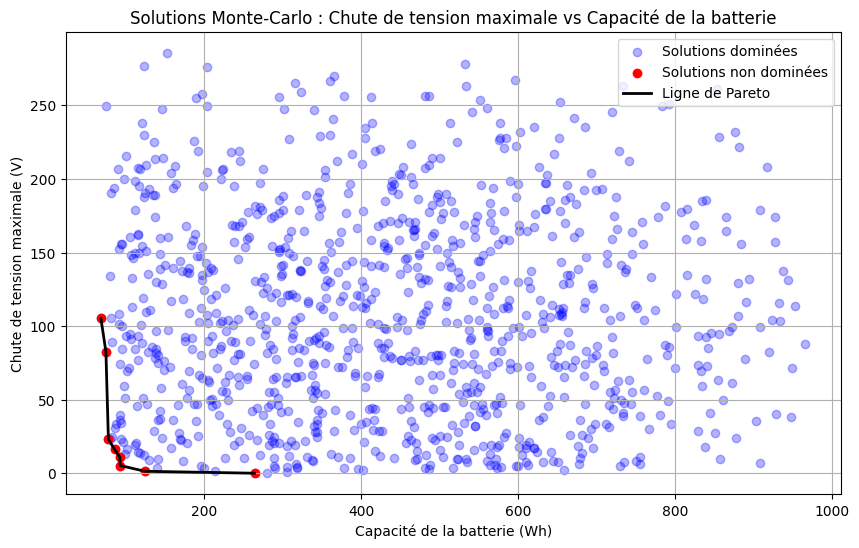

Solutions non dominées (Capacité de la batterie (Wh), Chute de tension maximale (V)): 
[[9.26934468e+01 5.31888289e+00]
 [7.75627277e+01 2.31261223e+01]
 [7.43868948e+01 8.26844014e+01]
 [8.54853054e+01 1.62235348e+01]
 [1.23963539e+02 1.40259216e+00]
 [2.63914060e+02 7.75364312e-02]
 [6.79742179e+01 1.05331611e+02]
 [9.20469683e+01 1.10790634e+01]]


In [45]:
# Paramètres du système (ajustés pour plus de diversité)
max_battery_capacity = 1000  # Capacité maximale de la batterie en Wh
max_voltage_drop = 290       # Chute de tension maximale en volts (par rapport à la tension nominale de 500V)
n_samples = 1000           # Augmentation du nombre d'échantillons pour obtenir plus de diversité

# Fonction pour simuler la capacité de la batterie et la chute de tension
def simulate_system(battery_capacity, voltage_drop_factor):
    # Simulation de la capacité de la batterie (en Wh)
    battery_energy = battery_capacity * np.random.uniform(0.6, 1.0)  # L'énergie varie entre 60% et 100% de la capacité maximale
    
    # Simulation de la chute de tension (en volts), en s'assurant que la chute ne dépasse pas max_voltage_drop
    voltage_drop = max_voltage_drop * np.random.uniform(0.0, 1.0) * voltage_drop_factor  # Facteur de variation de la chute
    
    return battery_energy, voltage_drop

# Échantillonnage aléatoire dans l'espace des décisions avec des plages plus larges
battery_capacities = np.random.uniform(100, max_battery_capacity, n_samples)  # Capacité de la batterie entre 100Wh et la capacité maximale
voltage_drop_factors = np.random.uniform(0.5, 1.0, n_samples)  # Facteur de chute de tension élargi entre 0.5 et 1.0

# Calcul des critères pour chaque échantillon
results = []
for i in range(n_samples):
    battery_energy, voltage_drop = simulate_system(battery_capacities[i], voltage_drop_factors[i])
    results.append([battery_energy, voltage_drop])

results = np.array(results)

# Fonction pour identifier les solutions non dominées (modifiée pour une domination stricte)
def non_dominated_sort(results):
    n = len(results)
    is_dominated = np.zeros(n, dtype=bool)
    
    for i in range(n):
        for j in range(n):
            # Modifiée la condition de domination : une solution est dominée si elle est pire sur les deux critères
            if (results[j, 0] <= results[i, 0] and results[j, 1] <= results[i, 1]) and (i != j):
                is_dominated[i] = True
                break
    
    return results[~is_dominated]

# Identification des solutions non dominées
non_dominated_solutions = non_dominated_sort(results)

# Trier les solutions non dominées pour créer la ligne de Pareto (en fonction de la capacité de la batterie, puis de la chute de tension)
sorted_non_dominated = non_dominated_solutions[np.argsort(non_dominated_solutions[:, 0])]

# Affichage des résultats
plt.figure(figsize=(10, 6))
plt.scatter(results[:, 0], results[:, 1], color='blue', alpha=0.3, label='Solutions dominées')
plt.scatter(non_dominated_solutions[:, 0], non_dominated_solutions[:, 1], color='red', label='Solutions non dominées')

# Tracer la ligne de Pareto en reliant les solutions non dominées triées
plt.plot(sorted_non_dominated[:, 0], sorted_non_dominated[:, 1], color='black', lw=2, label='Ligne de Pareto')

plt.xlabel('Capacité de la batterie (Wh)')
plt.ylabel('Chute de tension maximale (V)')
plt.title('Solutions Monte-Carlo : Chute de tension maximale vs Capacité de la batterie')
plt.legend()
plt.grid(True)
plt.show()

# Afficher les solutions non dominées
print("Solutions non dominées (Capacité de la batterie (Wh), Chute de tension maximale (V)): ")
print(non_dominated_solutions)

## Maintenant nous souhaitons implémenter un algorithme NGSA II pour déterminer la solution la plus optimale à notre problème.

Generation 0/100
Generation 10/100
Generation 20/100
Generation 30/100
Generation 40/100
Generation 50/100
Generation 60/100
Generation 70/100
Generation 80/100
Generation 90/100
Meilleure solution finale (Capacité de la batterie (Wh), Chute de tension maximale (V)): 
Chute de tension : 9.036538592172565 V
Capacité de la batterie : 338.8050405113893 Wh


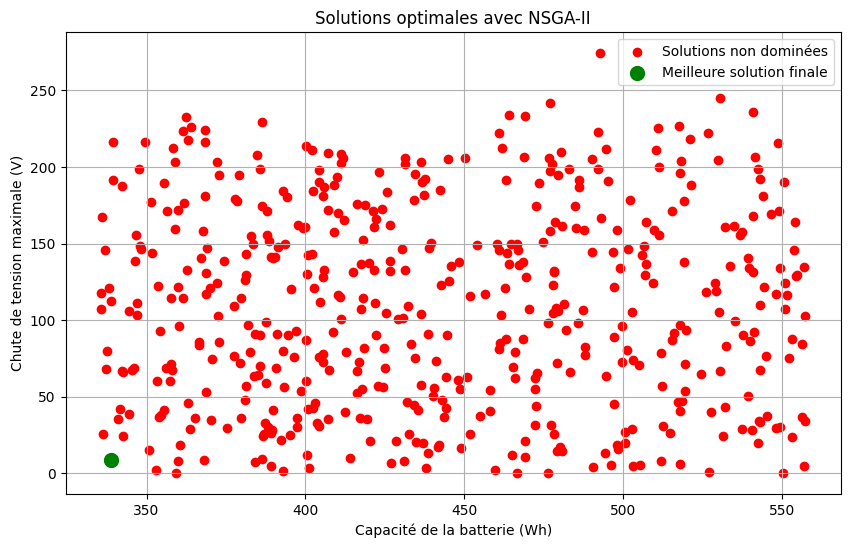

In [43]:
# Paramètres du système
max_battery_capacity = 1000  # Capacité maximale de la batterie en Wh
max_voltage_drop = 290       # Chute de tension maximale en volts (par rapport à la tension nominale de 500V)
n_samples = 1000            # Nombre d'échantillons pour obtenir plus de diversité
n_generations = 100          # Nombre de générations pour l'algorithme génétique
population_size = 500        # Taille de la population            ATTENTION : 10000 est un nombre très grand, cela peut prendre du temps
mutation_rate = 0.1          # Taux de mutation
crossover_rate = 0.9         # Taux de croisement

# Fonction pour simuler la capacité de la batterie et la chute de tension
def simulate_system(battery_capacity, voltage_drop_factor):
    battery_energy = battery_capacity * np.random.uniform(0.6, 1.0)  # L'énergie varie entre 60% et 100% de la capacité maximale
    voltage_drop = max_voltage_drop * np.random.uniform(0.0, 1.0) * voltage_drop_factor
    return battery_energy, voltage_drop

# Initialiser la population
def initialize_population(pop_size):
    battery_capacities = np.random.uniform(100, max_battery_capacity, pop_size)
    voltage_drop_factors = np.random.uniform(0.5, 1.0, pop_size)
    return np.column_stack((battery_capacities, voltage_drop_factors))

# Fonction pour évaluer la population
def evaluate_population(population):
    results = []
    for individual in population:
        battery_energy, voltage_drop = simulate_system(individual[0], individual[1])
        results.append([battery_energy, voltage_drop])
    return np.array(results)

# Fonction pour effectuer le croisement (crossover)
def crossover(parent1, parent2):
    if np.random.rand() < crossover_rate:
        # Croisement entre les parents (moyenne des deux)
        crossover_point = np.random.rand()
        child1 = crossover_point * parent1 + (1 - crossover_point) * parent2
        child2 = (1 - crossover_point) * parent1 + crossover_point * parent2
        return child1, child2
    else:
        return parent1, parent2

# Fonction de mutation
def mutate(individual):
    if np.random.rand() < mutation_rate:
        mutation = np.random.normal(0, 0.1, size=individual.shape)
        individual += mutation
        individual[0] = np.clip(individual[0], 100, max_battery_capacity)
        individual[1] = np.clip(individual[1], 0.5, 1.0)
    return individual

# Fonction de tri par domination non-dominée (NSGA-II)
def non_dominated_sort(population, fitness):
    n = len(population)
    fronts = [[]]
    domination_count = np.zeros(n)
    dominated_solutions = [[] for _ in range(n)]

    for p in range(n):
        for q in range(n):
            if (fitness[p, 0] >= fitness[q, 0] and fitness[p, 1] > fitness[q, 1]):
                dominated_solutions[p].append(q)
            elif (fitness[q, 0] >= fitness[p, 0] and fitness[q, 1] > fitness[p, 1]):
                domination_count[p] += 1
        if domination_count[p] == 0:
            fronts[0].append(p)

    front_index = 0
    while len(fronts[front_index]) > 0:
        next_front = []
        for p in fronts[front_index]:
            for q in dominated_solutions[p]:
                domination_count[q] -= 1
                if domination_count[q] == 0:
                    next_front.append(q)
        front_index += 1
        fronts.append(next_front)

    return fronts[:-1]

# Fonction de sélection
def selection(population, fronts, fitness):
    selected = []
    for front in fronts:
        if len(selected) + len(front) <= population_size:
            selected.extend(front)
        else:
            break
    return population[selected]

# Algorithme NSGA-II
def nsga2():
    population = initialize_population(population_size)
    fitness = evaluate_population(population)
    
    for generation in range(n_generations):
        # Sélection des parents
        fronts = non_dominated_sort(population, fitness)
        selected_population = selection(population, fronts, fitness)
        
        # Création de la nouvelle population
        new_population = []
        selected_population_indices = np.array([i for i in range(len(selected_population))])
        
        while len(new_population) < population_size:
            parent_indices = np.random.choice(selected_population_indices, 2, replace=False)
            parent1, parent2 = selected_population[parent_indices[0]], selected_population[parent_indices[1]]
            child1, child2 = crossover(parent1, parent2)
            new_population.append(mutate(child1))
            new_population.append(mutate(child2))
        
        # Évaluation des nouvelles solutions
        fitness = evaluate_population(new_population)
        
        # Mise à jour de la population
        population = np.array(new_population)
        fitness = np.array(fitness)
        
        # Affichage de l'état
        if generation % 10 == 0:
            print(f"Generation {generation}/{n_generations}")

    return population, fitness

# Exécution de l'algorithme NSGA-II
final_population, final_fitness = nsga2()

# Trouver la meilleure solution en minimisant simultanément la capacité de la batterie et la chute de tension
# La meilleure solution est celle qui minimise les deux critères simultanément
best_solution_index = np.argmin(final_fitness[:, 0] + final_fitness[:, 1])  # Somme des deux critères
best_solution = final_population[best_solution_index]
best_fitness = final_fitness[best_solution_index]

# Afficher la meilleure solution
print("Meilleure solution finale (Capacité de la batterie (Wh), Chute de tension maximale (V)): ")
print(f"Chute de tension : {best_fitness[1]} V")
print(f"Capacité de la batterie : {best_fitness[0]} Wh")

# Visualisation des solutions non dominées
plt.figure(figsize=(10, 6))
plt.scatter(final_fitness[:, 0], final_fitness[:, 1], color='red', label='Solutions non dominées')

# Ajouter la meilleure solution finale sur le graphe
plt.scatter(best_fitness[0], best_fitness[1], color='green', s=100, marker='o', label='Meilleure solution finale')

plt.xlabel('Capacité de la batterie (Wh)')
plt.ylabel('Chute de tension maximale (V)')
plt.title('Solutions optimales avec NSGA-II')
plt.legend()
plt.grid(True)
plt.show()

Peut importe le nombre de fois qu'on lance la simulation, on peut voir que la solution proposée par l'algorithme génétique est toujours 